# Neural Networks and Deep Learning for Life Sciences and Health Applications - An introductory course about theoretical fundamentals, case studies and implementations in python and tensorflow

(C) Umberto Michelucci 2018 - umberto.michelucci@gmail.com 

github repository: https://github.com/michelucci/dlcourse2018_students

Fall Semester 2018

## Helper Functions

Here is a quick helper function we will use to compare MSE for training and test dataset, to be able to check overfitting.

In [1]:
def compare_mse(sess, y_, train_x, test_x, kp):
    if (kp < 1):
        pred_y = sess.run(y_, feed_dict = {X:test_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x, keep_prob:kp})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))
    else:
        pred_y = sess.run(y_, feed_dict = {X:test_x})
        mse = tf.reduce_mean(tf.square(pred_y - test_y))
        print("MSE Test: %.4f" % sess.run(mse))

        pred_y = sess.run(y_, feed_dict = {X:train_x})
        mse = tf.reduce_mean(tf.square(pred_y - train_y))
        print("MSE Train: %.4f" % sess.run(mse))

## Libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

from sklearn.datasets import load_boston
import sklearn.linear_model as sk

For this demonstration I decided to use the Boston dataset, to have something different than the usual MNIST dataset that everyone is using. Altough I will dedicate a tutorial to that dataset too. First of all let's load the dataset and check it out.

In [3]:
boston = load_boston()
features = np.array(boston.data)
labels = np.array(boston.target)

In [4]:
print(boston["DESCR"])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Usually is better to normalize the different features, since this helps learning. We will do that with this function where we use numpy wonderful vectorized code.

In [5]:
def normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset-mu)/sigma

Let's get the dimension of the data set now

In [6]:
n_training_samples = features.shape[0]
n_dim = features.shape[1]

print('The dataset has',n_training_samples,'training samples.')
print('The dataset has',n_dim,'features.')

The dataset has 506 training samples.
The dataset has 13 features.


So in the variable ```n_training_samples``` we have the number of different input observations, and in the variable ```n_dim``` we have the number of features (or variables if you like) that we have at our disposal.

In [7]:
features_norm = normalize(features)

Now let's check the dimensions of our dataset and labels.

In [8]:
print(features_norm.shape)
print(labels.shape)

(506, 13)
(506,)


Let's build a train and a test sets splitting them randomly 80/20. We transposed the matrices since we will use a specific conventions later on when building our neurla networks. It is not a necessary steps if you are consistent when you write your neural networks.

In [9]:
np.random.seed(42)
rnd = np.random.rand(len(features_norm)) < 0.8

train_x = np.transpose(features_norm[rnd])
train_y = np.transpose(labels[rnd])
test_x = np.transpose(features_norm[~rnd])
test_y = np.transpose(labels[~rnd])

print(train_x.shape)
print(train_y.shape)

(13, 399)
(399,)


Note that in tensorflow we will define the lables (our ```train_y```) as a tensor of dimensions ```(n_training_samples*0.8, 1)``` so we will have to reshape the numpy array that otherwise has dimension ```(n_training_samples*0.8,)```. 

In [10]:
train_y = train_y.reshape(1,len(train_y))
test_y = test_y.reshape(1,len(test_y))

print(train_y.shape)
print(test_y.shape)

(1, 399)
(1, 107)


# Linear Regression

## Let's start with tensorflow modelling for a linear regression

Now keep in mind that is an overkill. We could solve linear regression exactly without the need of using gradient descent or similar optimisation algorithm. But I find it very instructive to see how to build such an easy model with tensorflow. The following diagram explain what kind of neural network we need to perform linear regression. To note is (for those with some more experience with neural networks) that we use one single neuron with an identity activation function. The term $WX+b$ is simply a linear combination of the input plus a constat term (bias) $b$. With $n_x$ we have indicated the number of observations we have at our disposal. $y\_$ is the predicted output given a certain input vector ${\bf x} = (x_1, x_2, ... , x_{n_x})$.

![](images/linear_model.png)

First we define the variables and placeholders we need to build the network above.

In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
learning_rate = tf.placeholder(tf.float32, shape=())

W = tf.Variable(tf.ones([n_dim, 1]))
b = tf.Variable(tf.zeros(1))

init = tf.global_variables_initializer()

Then we actually define the actual computation $WX+b$. Additionally we need to define the cost function $J$ we want to minimize. In case of regression this is simply the MSE. Then we choose which optimisation algorithm we want to use (in this case the gradient descent optimizer).

In [12]:
y_ = tf.matmul(tf.transpose(W),X)+b
cost = tf.reduce_mean(tf.square(y_-Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

To facilitate testing of several hyperparameters (in this case just the learning rate) we will define a function that will perform the training itself. To be able to call it with several values of the learning rate and see what happens.

In [13]:
def run_linear_model(learning_r, training_epochs, train_obs, train_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        sess.run(training_step, feed_dict = {X: train_obs, Y: train_labels, learning_rate: learning_r})
        cost_ = sess.run(cost, feed_dict={ X:train_obs, Y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
    
        if (epoch % 1000 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            
    return sess, cost_history

In [14]:
sess, cost_history = run_linear_model(learning_r = 0.01, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

Reached epoch 0 cost J = 613.947144
Reached epoch 1000 cost J = 22.131165
Reached epoch 2000 cost J = 22.081099
Reached epoch 3000 cost J = 22.076544
Reached epoch 4000 cost J = 22.076109
Reached epoch 5000 cost J = 22.076061
Reached epoch 6000 cost J = 22.076057
Reached epoch 7000 cost J = 22.076059
Reached epoch 8000 cost J = 22.076059
Reached epoch 9000 cost J = 22.076054
Reached epoch 10000 cost J = 22.076054


## Plot of the cost function

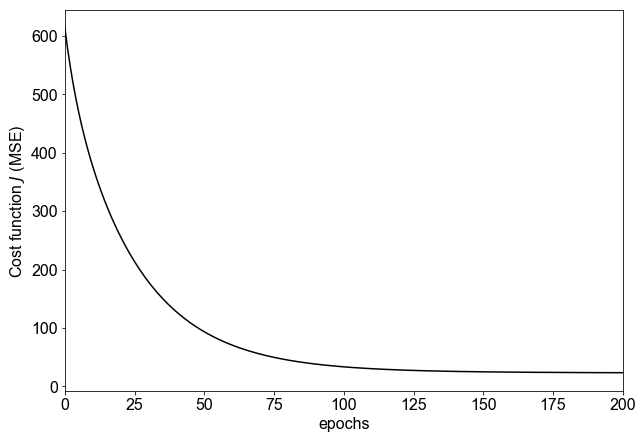

In [21]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.tight_layout()

fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history, ls='solid', color = 'black')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$ (MSE)', fontsize = 16)
plt.xlim(0,200)
plt.tick_params(labelsize=16)

Let's check the results plotting each observation on a plot where we have on the ```y``` axis the predicted value an on the ```x``` axis the measured value. If the model would get all observations perfectly right all points would be exactly on the diagonal line (that we have marked with a dashed line in the plot). The better the model the more the points aggregrate along the diagonal. The worse the model is the more scattered the points are.

## Figure 1-15: Predicted vs. measured

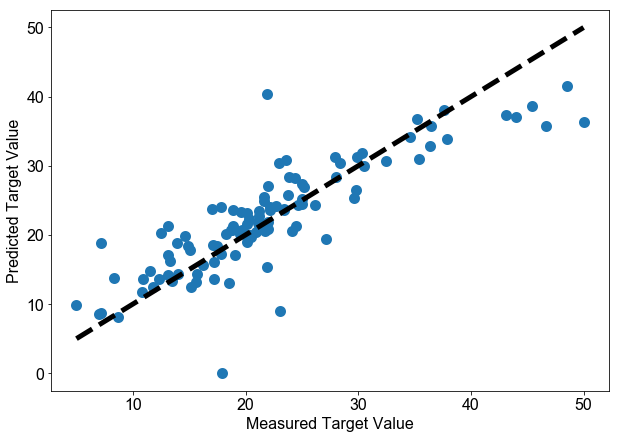

In [25]:
pred_y = sess.run(y_, feed_dict = {X: test_x, Y: test_y})
mse = tf.reduce_mean(tf.square(pred_y - test_y))

plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(test_y, pred_y, lw = 5)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw = 5)
ax.set_xlabel('Measured Target Value', fontsize = 16)
ax.set_ylabel('Predicted Target Value', fontsize = 16)
plt.tick_params(labelsize=16)

To check for overfitting (in case of linear regression this is an almost useless exercise, but I find it instructive) we need to compare the MSE for the train and test set

In [26]:
compare_mse(sess, y_, train_x, test_x, 1)

MSE Test: 23.0605
MSE Train: 22.0761


The two values are comparable.

In [27]:
sess.close()

## Different learning rates

Let's now try different learning rates and see what happens. 

In [28]:
print ('Starting first model')
sess1, cost_history1 = run_linear_model(learning_r = 0.1, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

print ('Starting second model')
sess2, cost_history2 = run_linear_model(learning_r = 0.01, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

print ('Starting third model')
sess3, cost_history3 = run_linear_model(learning_r = 0.001, 
                                training_epochs = 10000, 
                                train_obs = train_x, 
                                train_labels = train_y, 
                                debug = True)

Starting first model
Reached epoch 0 cost J = 373.735199
Reached epoch 1000 cost J = 22.076057
Reached epoch 2000 cost J = 22.076057
Reached epoch 3000 cost J = 22.076057
Reached epoch 4000 cost J = 22.076057
Reached epoch 5000 cost J = 22.076057
Reached epoch 6000 cost J = 22.076057
Reached epoch 7000 cost J = 22.076057
Reached epoch 8000 cost J = 22.076057
Reached epoch 9000 cost J = 22.076057
Reached epoch 10000 cost J = 22.076057
Starting second model
Reached epoch 0 cost J = 613.947144
Reached epoch 1000 cost J = 22.131165
Reached epoch 2000 cost J = 22.081099
Reached epoch 3000 cost J = 22.076544
Reached epoch 4000 cost J = 22.076109
Reached epoch 5000 cost J = 22.076061
Reached epoch 6000 cost J = 22.076057
Reached epoch 7000 cost J = 22.076059
Reached epoch 8000 cost J = 22.076059
Reached epoch 9000 cost J = 22.076054
Reached epoch 10000 cost J = 22.076054
Starting third model
Reached epoch 0 cost J = 651.279541
Reached epoch 1000 cost J = 34.158741
Reached epoch 2000 cost J = 

## Figure 1-16: different learning rates

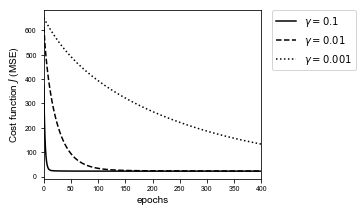

In [20]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(3.9, 3.1))
ax = fig.add_subplot(1, 1, 1)
   #x = np.linspace(1., 8., 30)
ax.plot(cost_history1, ls='solid', color = 'black', label='$\gamma=0.1$')
ax.plot(cost_history2, ls='dashed', color = 'black', label='$\gamma=0.01$')
ax.plot(cost_history3, ls='dotted', color = 'black', label='$\gamma=0.001$')
ax.set_xlabel('epochs')
ax.set_ylabel('Cost function $J$ (MSE)')
plt.xlim(0,400)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig('Figure_1-16'+'.pdf', format='pdf', dpi=300,bbox_inches='tight')
fig.savefig('Figure_1-16'+'.png', format='png', dpi=300,bbox_inches='tight')

As expected the higher the learning rate the faster it converges to a low value (the one we expect from the linear model we are using). Note that this is a very trivial model. In real cases what happens is that if the learning rate is too big the model very often will not converge, since it will not be able to converge to a minimum. Several books and blogs discuss this problem at length. 

What we are doing here is a very basic and trivial hypterparameter tuning. To find out which model (in this case which hyperparameters) are the best for our problem. In this case it seems quite clear that a learning rate of 0.1 seems a good choice. It does not require so many epochs to converge to the minimum value we have.

In [21]:
sess1.close()
sess2.close()
sess3.close()

Just to compare our results, let's use sklearn library to perform a classical linear regression. It will be useful to see what MSE we can get from a classical/standard linear regression and compare it with what we get with our neural network. 

**HINT:** the two values should be **very** similar, and they should tend to become the same.

In [22]:
lm = sk.LinearRegression()
lm.fit(np.transpose(train_x), np.transpose(train_y))
msetest = np.mean((np.transpose(test_y)-lm.predict(np.transpose(test_x)))**2)
msetrain = np.mean((np.transpose(train_y)-lm.predict(np.transpose(train_x)))**2)

print('Train MSE=',msetrain)
print('Test MSE=',msetest)

Train MSE= 22.0760561914
Test MSE= 23.0604521841


/Users/umberto/tensorflow3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


With our Neural network we got 22.076054 a value that is very close to what we see here of 22.076056. What this tells us, is that our neural network got almost the best possible value we can get. Pretty neat!

**Note** is important to note that this (the one coming from the linear regression) is the minimum value we can get for the cost function. To do better we need to use a more complex model, a non linear model. To see what we can do let's try to use more complex network architecture, but let's start with something easy. Remember we have only 13 features and (in the training set) roughly 400 observations. So we need to be aware that it will be easy to overfit the training data. This is why is important to have a test dataset at our disposal to check this.